In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Data understanding

In [3]:
df_sales = pd.read_csv("../data/raw/sales_train.csv")
df_sales.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [4]:
df_items = pd.read_csv("../data/raw/items.csv")
df_items.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [5]:
df_item_categories = pd.read_csv("../data/raw/item_categories.csv")
df_item_categories.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [6]:
df_shops = pd.read_csv("../data/raw/shops.csv")
df_shops.head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [7]:
df_test = pd.read_csv("../data/raw/test.csv")
print(f"Shape: {df_test.shape}")
df_test.head()

Shape: (214200, 3)


,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


**First Impressions**

- as stated in challenge's description, the test set has only one month while the train set has days/day/item.
- as stated in challenge's description, and at first glance, the other provided files do not add any value to the forecast analysis.

## Exploring df_sales

In [8]:
df_sales.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [9]:
df_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype  
---  ------          -----  
 0   date            object 
 1   date_block_num  int64  
 2   shop_id         int64  
 3   item_id         int64  
 4   item_price      float64
 5   item_cnt_day    float64
dtypes: float64(2), int64(3), object(1)
memory usage: 134.4+ MB


In [10]:
df_sales["year_month"] = df_sales["date"].str.slice(start=-4) + df_sales["date"].str.slice(start=3, stop=5)
df_sales.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,year_month
0,02.01.2013,0,59,22154,999.00,1.0,201301
1,03.01.2013,0,25,2552,899.00,1.0,201301
2,05.01.2013,0,25,2552,899.00,-1.0,201301
3,06.01.2013,0,25,2554,1709.05,1.0,201301
4,15.01.2013,0,25,2555,1099.00,1.0,201301


In [11]:
print(f"""Unique values:
      - year_month: {df_sales["year_month"].nunique()}
      - date_block_num: {df_sales["date_block_num"].nunique()}
      - shop_id: {df_sales["shop_id"].nunique()}
      - item_id: {df_sales["item_id"].nunique()}""")

Unique values:
      - year_month: 34
      - date_block_num: 34
      - shop_id: 60
      - item_id: 21807


## Exploring df_test

In [12]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214200 entries, 0 to 214199
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype
---  ------   --------------   -----
 0   ID       214200 non-null  int64
 1   shop_id  214200 non-null  int64
 2   item_id  214200 non-null  int64
dtypes: int64(3)
memory usage: 4.9 MB


In [13]:
print(f"""Unique values:
      - shop_id: {df_test["shop_id"].nunique()}
      - item_id: {df_test["item_id"].nunique()}""")

Unique values:
      - shop_id: 42
      - item_id: 5100


## Verifying if the values in df_test exist in df_sales

Here I would like to verify if the shop_id and item_id values are in train dataset.

In [14]:
df_test.tail()

,ID,shop_id,item_id
214195,214195,45,18454
214196,214196,45,16188
214197,214197,45,15757
214198,214198,45,19648
214199,214199,45,969


In [15]:
df = df_test.groupby(by=["shop_id", "item_id"]).agg({"ID":["count", "nunique"]})
df.head()

ID        
                count nunique
shop_id item_id              
2       30          1       1
        31          1       1
        32          1       1
        33          1       1
        38          1       1

In [16]:
df[("ID")].value_counts()

count  nunique
1      1          214200
dtype: int64

In [17]:
df_sales.head()
# df_sales.groupby(by=["year_month", "shop_id", "item_id"]).agg({"ID":["count", "nunique"]})
# df_sales.groupby(by=["shop_id", "item_id"]).size()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,year_month
0,02.01.2013,0,59,22154,999.00,1.0,201301
1,03.01.2013,0,25,2552,899.00,1.0,201301
2,05.01.2013,0,25,2552,899.00,-1.0,201301
3,06.01.2013,0,25,2554,1709.05,1.0,201301
4,15.01.2013,0,25,2555,1099.00,1.0,201301


In [22]:
df = df_test.merge(df_sales, how='left', on=["shop_id", "item_id"])
len(df.loc[df["ID"].isnull(), "item_id"])

0

In [31]:
df = df_sales.merge(df_test, how='left', on=["shop_id", "item_id"])
df = df.loc[df["ID"].isnull(), ["shop_id", "item_id"]]
len(df)

1711410

## Creating the train dataset according to the output format

In [65]:
df_train = df_sales.copy()
df_train = df_train.groupby(by=["year_month","shop_id", "item_id"]).agg({"item_cnt_day": "sum"}).rename(columns={"item_cnt_day": "item_cnt_month"}).reset_index()
df_train["year"] = df_train["year_month"].str.slice(stop=4).astype(int)
df_train["month"] = df_train["year_month"].str.slice(start=-2).astype(int)
df_train = df_train[["year", "month", "shop_id", "item_id", "item_cnt_month"]]
df_train.head()

,year,month,shop_id,item_id,item_cnt_month
0,2013,1,0,32,6.0
1,2013,1,0,33,3.0
2,2013,1,0,35,1.0
3,2013,1,0,43,1.0
4,2013,1,0,51,2.0


<AxesSubplot:xlabel='month', ylabel='item_cnt_month'>

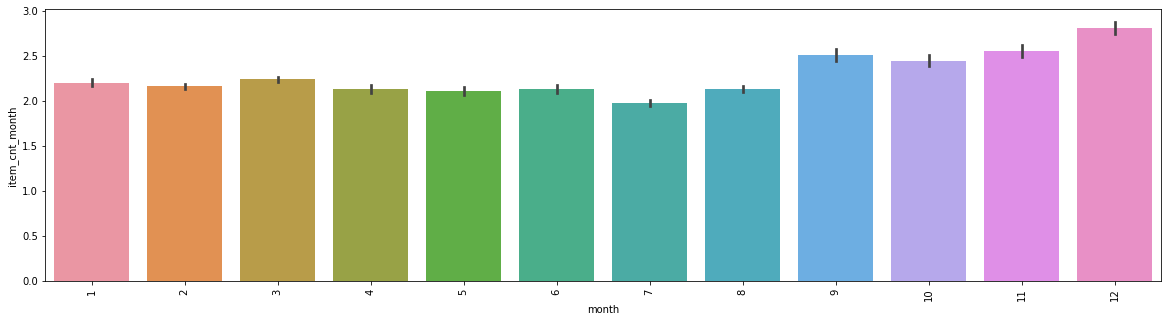

In [38]:
# plt.subplots(nrows=3, ncols=12, figsize=(20,5))
# for date_block in df_train["date_block_num"].unique():

plt.subplots(figsize=(20,5))
plt.xticks(rotation=90)
sns.barplot(x="month", y="item_cnt_month", data=df_train);

In [62]:
df_test_mod = df_test.copy()
df_test_mod = df_test_mod.groupby(["shop_id", "item_id"]).agg({"ID": "count"}).rename(columns={"ID": "item_cnt_month"}).reset_index()
df_test_mod["year"] = 2015
df_test_mod["month"] = 11
df_test_mod = df_test_mod[df_train.columns.tolist()]

df_test_mod.head()

,year,month,shop_id,item_id,item_cnt_month
0,2015,11,2,30,1
1,2015,11,2,31,1
2,2015,11,2,32,1
3,2015,11,2,33,1
4,2015,11,2,38,1


# Baseline model

Let's get a baseline from a random forest model.

In [66]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error as rmse

In [68]:
model = RandomForestRegressor(n_jobs=-1)
model.fit(df_train.drop("item_cnt_month", axis=1), df_train["item_cnt_month"])

RandomForestRegressor(n_jobs=-1)

In [69]:
y_pred = model.predict(df_test_mod.drop("item_cnt_month", axis=1))

In [71]:
df_test_mod["y_pred"] = y_pred
df_test_mod.head()

,year,month,shop_id,item_id,item_cnt_month,y_pred
0,2015,11,2,30,1,1.29
1,2015,11,2,31,1,1.41
2,2015,11,2,32,1,1.65
3,2015,11,2,33,1,1.33
4,2015,11,2,38,1,1.18


In [70]:
rmse(df_test_mod["item_cnt_month"], y_pred)

53.20243650466851

# Adding new features and transforming others

In [40]:
df_train["month_sin"] = np.sin(2 * np.pi * df_train["month"]/12.0)
df_train["month_cos"] = np.cos(2 * np.pi * df_train["month"]/12.0)
df_train["year"] = df_train["year"] - df_train.loc[0, "year"] + 1
df_train.head()

,year,month,shop_id,item_id,item_cnt_month,month_sin,month_cos
0,1,1,0,32,6.0,0.5,0.866025
1,1,1,0,33,3.0,0.5,0.866025
2,1,1,0,35,1.0,0.5,0.866025
3,1,1,0,43,1.0,0.5,0.866025
4,1,1,0,51,2.0,0.5,0.866025
